In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.fastai.conv_learner import *
from fastai.fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

20_words.csv	 lines	    tmp		       words		words.tgz
ascii		 lines.tgz  word_char_ids.csv  words_chars.csv
line_labels.csv  models     word_labels.csv    words.csv


In [5]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [6]:
from PIL import Image

def open_image(fname, folder='words'):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(PATH/folder/f)

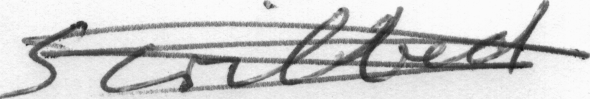

In [7]:
open_image('p06-047-08-00')

# Words

### Explore Data

In [27]:
# https://github.com/githubharald/SimpleHTR/blob/master/src/Model.py
    
# imgSize = (128, 32)
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])

In [28]:
data = np.stack(samples)
data.shape

(115320, 2)

In [61]:
data[:,1]

array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'],
      dtype='<U32')

In [29]:
len(chars)

78

### Remove all rows where value count < 20 (word images)

In [34]:
# sort by label count
pivot = word_labels.pivot_table(index='value', aggfunc=len).sort_values('filename', ascending=False)
len(pivot)  # total num unique words

10867

In [35]:
# only keep values with counts > 20
pivot = pivot[pivot.filename > 20]
len(pivot)  # 344 unique words seen more than 20 times

406

In [36]:
value_mask = np.array(pivot.index)
value_mask

array(['the', ',', '.', 'of', 'to', 'and', 'a', 'in', 'that', 'was', 'is', 'for', 'he', 'had', 'be', 'with',
       'as', 'I', 'on', 'it', 'his', "'", 'The', 'at', 'by', 'not', 'which', 'but', 'have', 'an', 'are',
       'been', 'this', 'Mr.', 'from', 'has', 'were', '-', 'or', 'you', 'will', 'we', 'they', 'It', 'He',
       'who', 'would', 'their', 'all', 'her', 'more', '!', ';', 'so', '(', ')', 'than', 'one', 'said',
       'there', 'may', 'being', 'him', 'out', 'no', 'In', 'them', 'first', ':', 'she', 'up', 'when', 'about',
       'A', 'man', 'two', 'other', '...', 'into', '?', 'But', 'what', 'like', 'me', 'if', 'new', 'some',
       'its', 'my', 'can', 'Anglesey', 'very', 'Sir', 'This', 'only', 'made', 'could', 'people', 'much',
       'do', 'time', 'years', 'over', 'ever', 'told', 'these', 'our', 'well', 'great', 'should', 'year',
       'And', 'any', 'most', 'even', 'now', 'What', 'We', 'God', 'found', 'before', 'must', 'under', 'then',
       'back', 'life', 'good', 'last', 'per'

In [37]:
# apply value_mask to original csv
word_labels = word_labels[word_labels.value.isin(value_mask)]
len(word_labels)

49504

### Numericalize characters

In [21]:
itos = sorted(list(chars))
len(itos)

78

In [22]:
itos.insert(0, '_pad_')
itos.insert(1, '_unk_')

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in data[:,1]])

In [63]:
ids

array([array([28]), array([40, 42, 49, 32]), array([73, 68]), ..., array([73, 61, 58]),
       array([60, 54, 71, 57, 58, 67]), array([27])], dtype=object)

In [111]:
# convert to strings (as labels)
strs = np.array([' '.join(str(l) for l in w) for w in ids])

In [81]:
ids.shape, data.shape, strs.shape

((115320,), (115320, 2), (115320,))

In [112]:
# need to make strs a 2d array to allow for concatenation onto data
z = strs.reshape(-1,1)

In [113]:
data = np.concatenate((data, z), axis=1)
data[:10]

array([['a01-000u-00-00', 'A', '28'],
       ['a01-000u-00-01', 'MOVE', '40 42 49 32'],
       ['a01-000u-00-02', 'to', '73 68'],
       ['a01-000u-00-03', 'stop', '72 73 68 69'],
       ['a01-000u-00-04', 'Mr.', '40 71 13'],
       ['a01-000u-00-05', 'Gaitskell', '34 54 62 73 72 64 58 65 65'],
       ['a01-000u-00-06', 'from', '59 71 68 66'],
       ['a01-000u-01-00', 'nominating', '67 68 66 62 67 54 73 62 67 60'],
       ['a01-000u-01-01', 'any', '54 67 78'],
       ['a01-000u-01-02', 'more', '66 68 71 58']],
      dtype='<U95')

In [114]:
# convert numpy array to dataframe
df = pd.DataFrame(data, columns=['filename', 'label', 'values'])
df.head()

,filename,label,values
0,a01-000u-00-00,A,28
1,a01-000u-00-01,MOVE,40 42 49 32
2,a01-000u-00-02,to,73 68
3,a01-000u-00-03,stop,72 73 68 69
4,a01-000u-00-04,Mr.,40 71 13


In [23]:
np.save(TMP_PATH/'word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'word_itos.pkl', 'wb'))

### Save to CSV

In [7]:
ids = np.load(TMP_PATH/'word_ids.npy')
itos = pickle.load(open(TMP_PATH/'word_itos.pkl', 'rb'))

### Words/Chars

In [8]:
CSV = f'{PATH}/words.csv'
CHARS = f'{PATH}/words_chars.csv'

In [9]:
# df.to_csv(CHARS, columns=['filename', 'values'], index=False)
chars = pd.read_csv(CHARS)
chars.head()

,filename,chars
0,a01-000u-00-00,1 32
1,a01-000u-00-02,1 77 72
2,a01-000u-00-03,1 76 77 72 73
3,a01-000u-00-04,1 44 75 17
4,a01-000u-00-06,1 63 75 72 70


In [10]:
# df.to_csv(CHARS, columns=['filename', 'values'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-02,to
2,a01-000u-00-03,stop
3,a01-000u-00-04,Mr.
4,a01-000u-00-06,from


### Get val_idxs

In [11]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

11968

### Preprocess (rotate, normalize)

In [10]:
f = resnet34
sz = 64
bs = 120

In [65]:
aug_tfms = [RandomRotate(5),  # transform type Classification
            RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs,
                                    tfms=tfms, suffix='.png', continuous=True)

In [66]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [42]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [18]:
x.shape

(50, 64, 64, 3)

In [19]:
y.shape

torch.Size([50, 11])

### View image transforms

In [21]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [22]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

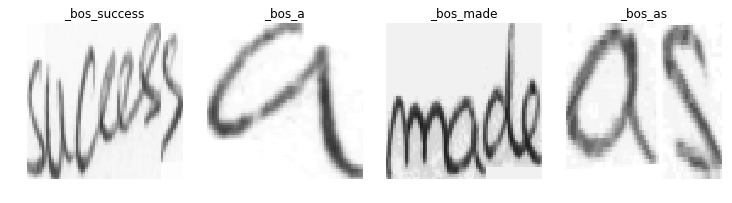

In [26]:
fig, axes = plt.subplots(1,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[0][i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

## Simple Word CNN

In [13]:
f = resnet34
sz = 64
bs = 120

In [14]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [15]:
learn = ConvLearner.pretrained(f, data, ps=0.5, precompute=True)
learn.opt_fn = optim.Adam

 73%|███████▎  | 412/566 [00:09<00:03, 42.65it/s, loss=11.9]


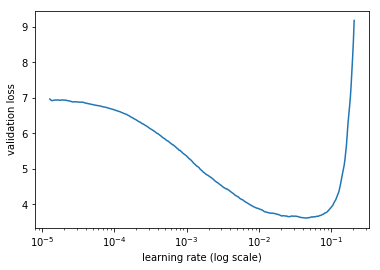

In [25]:
learn.lr_find()
learn.sched.plot()

In [16]:
lr = 1e-2

### Train

In [27]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.582719   2.191832   0.512032  
    1      2.396545   1.988855   0.541026                   



[1.9888547962521488, 0.5410260672676054]

In [28]:
learn.precompute=False

In [29]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      2.217494   1.850627   0.569184  
    1      2.112      1.789572   0.580966                   
    2      2.104576   1.752978   0.583138                   



[1.7529784287201529, 0.5831383693026987]

In [64]:
learn.save('words20-.60acc')

In [17]:
learn.unfreeze()

 70%|███████   | 398/566 [00:47<00:20,  8.34it/s, loss=6.59]

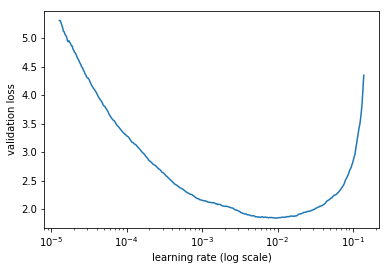

In [31]:
learn.lr_find()
learn.sched.plot()

In [32]:
lrs = np.array([lr/100, lr/30, lr/10])

In [33]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.186621   0.991528   0.761113  
    1      0.892342   0.721315   0.821106                    
    2      0.616859   0.603324   0.855281                    
    3      0.685103   0.607994   0.850936                    
    4      0.481037   0.531042   0.874164                    
    5      0.306763   0.482539   0.895053                    
    6      0.209561   0.472004   0.899148                    


[0.47200431002373683, 0.8991477309780962]

In [34]:
learn.save('words64-.90acc') # minimum frequency = 20
# learn.save('words-.49acc')   # minimum frequency = 5

### Increase size

In [35]:
sz = 128

In [37]:
learn.set_data(data)

In [38]:
learn.freeze()

 73%|███████▎  | 411/566 [00:47<00:17,  8.70it/s, loss=8.42]

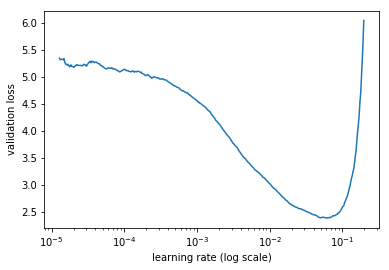

In [39]:
learn.lr_find()
learn.sched.plot()

In [40]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.457656   1.051355   0.741895  
    1      1.249293   0.920189   0.773981                   


[0.9201892623528439, 0.7739806132998696]

In [41]:
learn.save('words128-last_layer-.77')

In [71]:
learn.load('words128-last_layer-.77')

In [72]:
learn.unfreeze()

In [73]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.543593   0.451953   0.899315  
    1      0.468808   0.418607   0.908339                    
    2      0.303968   0.373624   0.920956                    


[0.37362350284913803, 0.9209558813967169]

In [44]:
learn.save('words128-.93')

### Predict

In [ ]:
learn.load('words128-.93')

In [76]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs,y)

0.9217914438502673

In [46]:
preds = np.argmax(probs, axis=1)

### Results

In [95]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [62]:
def plots(ims, figsize=(12,6), rows=1, titles=None, texts=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
#         sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        if texts is not None: sp.set_xlabel(texts[i])
        plt.imshow(ims[i])

In [63]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH/ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    labels = [data.classes[preds[x]] + ' - ' + data.classes[data.val_y[x]] for x in idxs]
    texts = [data.val_ds.fnames[x] for x in idxs]
    print(title)
    print(texts)
    return plots(imgs, rows=(len(idxs)//4), titles=labels, texts=texts, figsize=(16,8))

Correctly classified


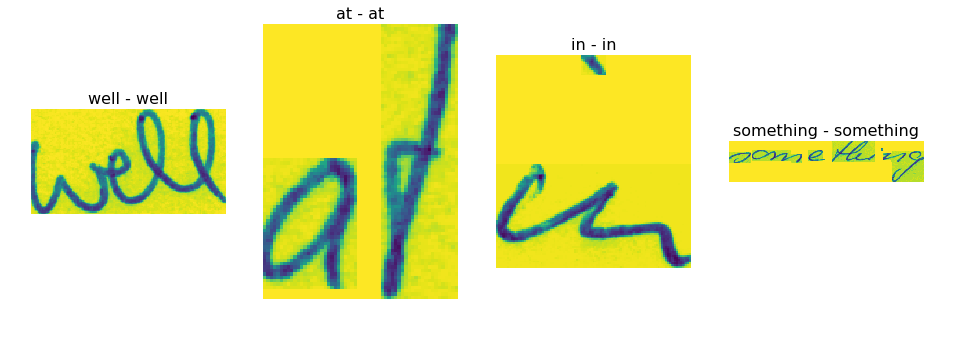

In [52]:
# correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified
['words/e01-029-06-05.png', 'words/c02-035-03-04.png', 'words/m02-055-03-01.png', 'words/f07-042a-06-00.png']


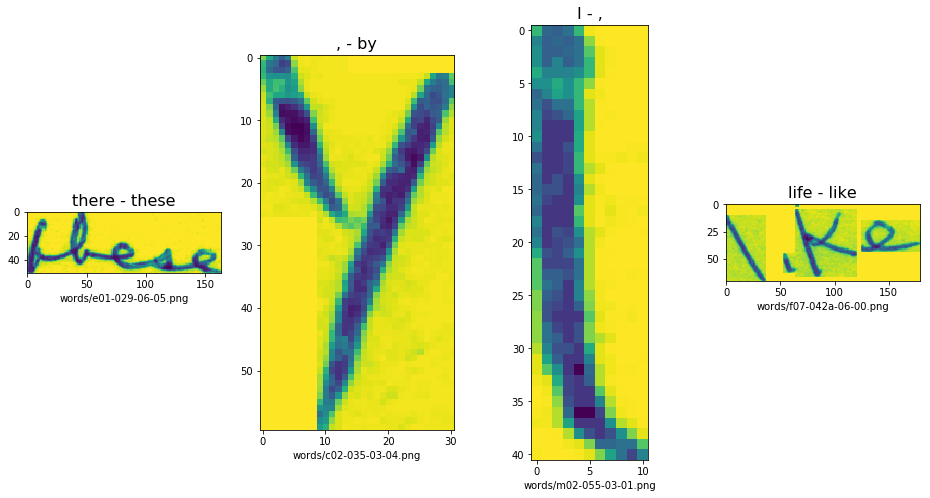

In [58]:
# incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [80]:
# all incorrect
# incorrect = np.where((preds == data.val_y)==False)[0]
len(incorrect)

861

Incorrectly classified
['words/a01-003-02-06.png', 'words/a01-003-06-02.png', 'words/a01-003u-03-05.png', 'words/a01-007x-00-08.png', 'words/a01-011u-06-04.png', 'words/a01-011x-01-05.png', 'words/a01-011x-03-03.png', 'words/a01-011x-03-04.png', 'words/a01-014-06-04.png', 'words/a01-020u-06-04.png']


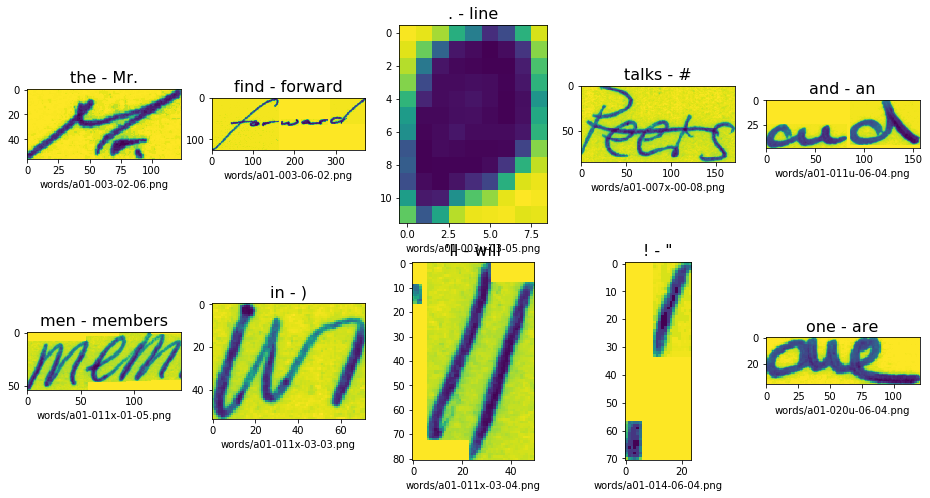

In [99]:
plot_val_with_title(incorrect[:10], "Incorrectly classified")

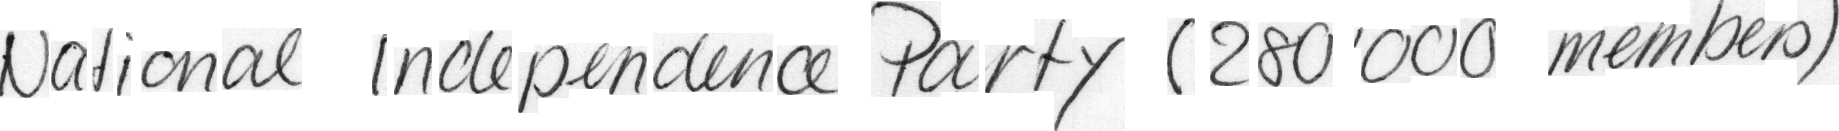

In [122]:
open_image('a01-011x-01', 'lines')

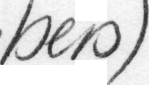

In [123]:
open_image('a01-011x-01-06')

In [124]:
csv[csv.filename=='a01-011x-01-06']

,filename,word
484,a01-011x-01-06,)


## With Chars

In [12]:
f = resnet34
sz = 64
bs = 120

In [101]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [102]:
#save word values and classes to combine w/ char dataset
val_words,trn_words = data.val_y,data.trn_y
word_classes = data.classes

In [103]:
md = ImageClassifierData.from_csv(PATH, 'words', CHARS, bs=bs, val_idxs=val_idxs,
                                    tfms=tfms, suffix='.png', continuous=True)

In [104]:
# pad ends of lines with pad token for language model
md.aug_dl.pre_pad=False
md.trn_dl.pre_pad=False
md.val_dl.pre_pad=False

In [105]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [106]:
comb_trn_ds = ConcatLblDataset(md.trn_ds, trn_words)
comb_val_ds = ConcatLblDataset(md.val_ds, val_words)
md.trn_dl.dataset = comb_trn_ds
md.val_dl.dataset = comb_val_ds

In [19]:
denorm = md.trn_ds.ds.denorm   # need the extra .ds when using ConcatLblDataset
x,y = next(iter(md.trn_dl))
x = denorm(x)

In [26]:
y[0][0], y[1][0]

(tensor([  1.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], device='cuda:0'),
 tensor(13, device='cuda:0'))

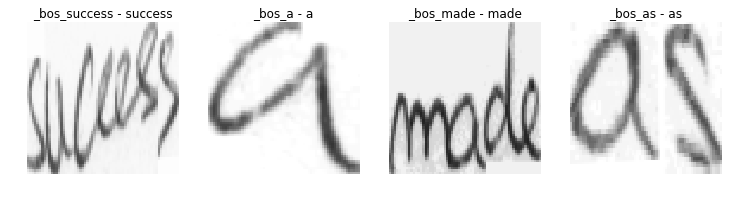

In [27]:
fig, axes = plt.subplots(1,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[0][i])                 #chars
    t += ' - ' + word_classes[y[1][i]]      #words
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Architecture

In [28]:
len(word_classes), len(itos)

(568, 84)

In [29]:
sl=20

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.4):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x):
    bs,c,h,w = x.size()
#     x = x.permute(0,2,3,1).contiguous()
#     return x.view(bs,-1,c)
    return x.squeeze()

class OutConv(nn.Module):
    def __init__(self, sl, nin, bias):
        super().__init__()
        self.sl = sl
        self.char_conv = nn.Conv2d(nin, (len(itos)*sl), 3, padding=1)
        self.word_conv = nn.Conv2d(nin, (len(word_classes)+1), 3, padding=1)
#         self.oconv_words.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.char_conv(x)),
                flatten_conv(self.word_conv(x))]

In [30]:
class SSD_Head(nn.Module):
    def __init__(self, sl, bias):
        super().__init__()
        self.drop = nn.Dropout(0.4)
        self.pool = nn.AdaptiveMaxPool2d(2)      #(bs,sz,2,2)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256)
#         self.sconv2 = StdConv(256,256)
        self.out = OutConv(sl, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.pool(x)
        x = self.sconv0(x)
        x = self.sconv1(x)
#         x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(sl, -3.)
models = ConvnetBuilder(f, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

### Loss

In [38]:
def comb_loss(pred, targ):
    char_pred,word_pred = pred    # ([bs, 1680]), ([bs, 569])
    char_targ,word_targ = targ    # ([bs, 9]), ([bs])
    
    sl = 20
    bs,num_chars = char_targ.shape
    char_pred = char_pred.view(bs, sl, -1)   # convert to ([bs, sl, 84])
    
    if num_chars<sl: char_targ = F.pad(char_targ, (0,sl-num_chars,0,0)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    
    #char_pred = char_pred[:, :num_chars, :].contiguous()   # take only the first num_chars of char_pred
    
    word_loss = F.cross_entropy(word_pred, word_targ)
    char_loss = F.cross_entropy(char_pred.view(bs*sl, -1), char_targ.view(-1).long())  #=> ([1000, 80]), ([1000])
#     print('word: '+str(word_loss.item())+' -- char_loss: '+str(char_loss.item()))
    return word_loss + char_loss

In [39]:
def word_acc(preds, targs):
    _,word_preds = preds    # ([bs, 569])
    _,word_targs = targs    # ([bs])
    
    preds = torch.max(word_preds, dim=1)[1]
    return (preds==word_targs).float().mean()

def char_acc(preds, targs):
    char_preds,_ = preds    # ([bs, 1680])
    char_targs,_ = targs    # ([bs, 9])
    
    bs,num_chars = char_targs.shape
    char_preds = char_preds.view(bs, 20, -1)   # convert to ([bs, sl, 84])
    char_preds = char_preds[:, :num_chars, :].contiguous()   # take only the first num_chars of char_pred
    
    preds = torch.max(char_preds.view(bs*num_chars, -1), dim=1)[1]
    return (preds==char_targs.view(-1).long()).float().mean()

In [40]:
learn.crit = comb_loss
learn.metrics = [word_acc, char_acc]

### Train

 76%|███████▌  | 430/566 [00:49<00:15,  8.64it/s, loss=16.1]

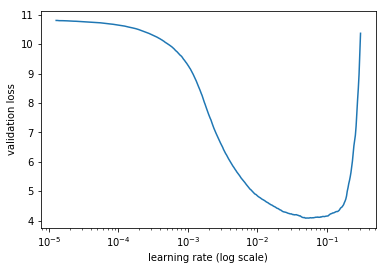

In [41]:
learn.lr_find()
learn.sched.plot()

In [42]:
lr = 1e-2

In [43]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   word_acc   char_acc        
    0      2.859119   2.491052   0.508523   0.818683  
    1      2.607414   2.218439   0.552807   0.829452        
    2      2.500668   2.081812   0.570354   0.834209        


[2.0818121869933797, 0.5703542790908546, 0.8342093802231518]

In [44]:
learn.unfreeze()

 73%|███████▎  | 415/566 [01:04<00:23,  6.42it/s, loss=8.87]

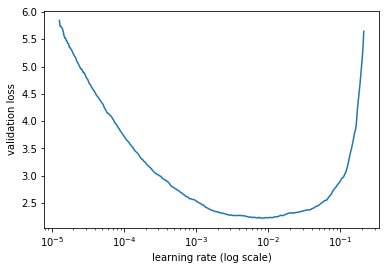

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lrs = np.array([lr/100, lr/30, lr/10])

In [47]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   word_acc   char_acc        
    0      1.677551   1.456148   0.696023   0.870873  
    1      1.283353   1.040689   0.783255   0.896116        
    2      0.953702   0.895559   0.820605   0.905728         
    3      1.001827   0.855498   0.824365   0.912475        
    4      0.746396   0.71591    0.857955   0.924944         
    5      0.526449   0.637593   0.880849   0.932924         
    6      0.415162   0.614242   0.886364   0.935829         


[0.6142422643136531, 0.886363639112781, 0.9358286812981182]

In [48]:
learn.save('words-chars64-.61loss')   # word_acc: .886, char_acc: .936

In [39]:
learn.load('words-chars64-.61loss')

In [52]:
#increase dropout and re-fit
learn.fit(lrs, 4)

epoch      trn_loss   val_loss   word_acc   char_acc         
    0      0.549571   0.615238   0.898396   0.955028  


[0.6152381958529592, 0.8983957209689094, 0.955027851310962]

In [53]:
learn.save('words-chars64-.61loss')   # word_acc: .898, char_acc: .955

### Predict

In [74]:
x,y = next(iter(md.val_dl))
x,y = V(x).cpu(),V(y)
learn.model.eval()
char_pred,word_pred = learn.model(x)

In [98]:
char_targ, word_targ = y[0].cpu(), y[1].cpu()
bs,num_chars = char_targ.shape

sl = 20
if num_chars<sl: char_targ = F.pad(char_targ, (0,sl-num_chars,0,0)) # rank2 tensor requires 4 padding values
char_targ = char_targ.long()
    
char_preds = char_pred.view(bs, 20, -1)   # convert to ([bs, sl, 84])
# char_preds = char_preds[:, :num_chars, :].contiguous()   # take only the first num_chars of char_pred

In [82]:
w_preds = np.argmax(word_pred.detach(), axis=1)
c_preds = np.argmax(char_preds.detach(), axis=2)

In [ ]:
x = denorm(x)

In [53]:
def char_text(pred):
    ints = to_np(pred).astype(int)
#     dx = np.where(ints==0)[0]
#     if np.any(dx):                 # if any padding tokens, get idx of first one
#         idx = dx[0]
#     else:
#         idx = -1                   
#     ints = ints[:idx]              # remove ints after first padding token
    ints = np.trim_zeros(ints)    # remove padding (0)
    ints = np.delete(ints, 0)      # remove _bos_ token
    return ''.join([itos[i] for i in ints])

def word_text(pred):
    return word_classes[pred]

In [54]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

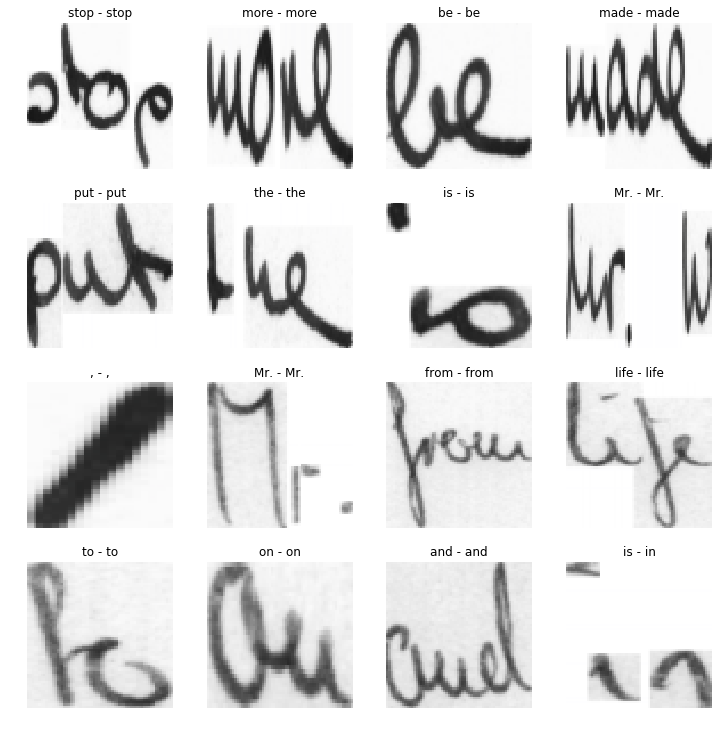

In [56]:
# WORDS
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = word_text(y[1][i].item())      #=>  words
    t += ' - '+word_text(w_preds[i])
    #t += ' - '+char_text(y[0][i])     #=>  char indices
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

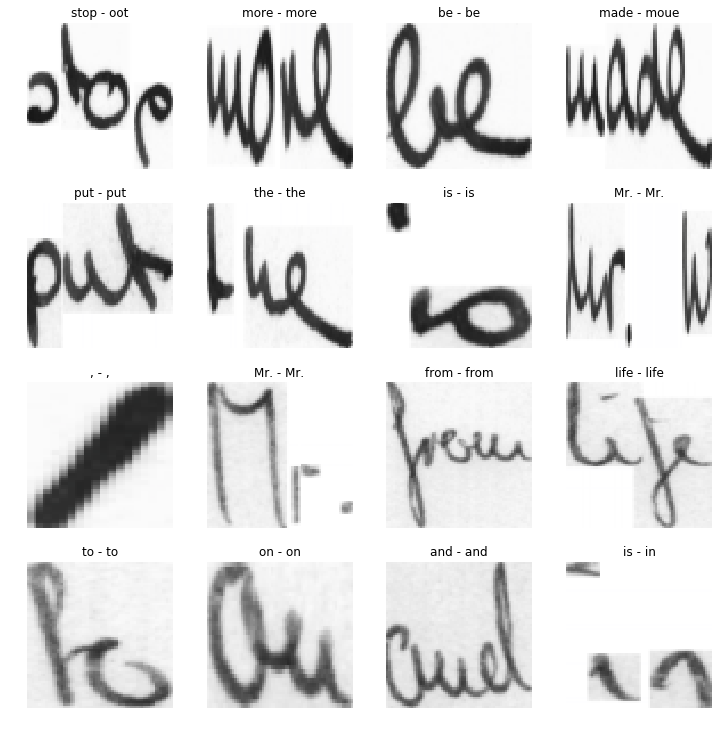

In [57]:
# CHARS
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = char_text(y[0][i])     #=>  char indices
    t += ' - '+char_text(c_preds[i])
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

In [58]:
def rand_by_mask(mask, num):
    total = np.where(mask)[0]
    num = min(num, len(total))
    return np.random.choice(total, num, replace=False)
def rand_by_correct(is_correct, preds, targs, num=4): return rand_by_mask((preds == targs)==is_correct, num)

In [59]:
def plots(ims, figsize=(12,6), rows=1, titles=None, texts=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
#         sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        if texts is not None: sp.set_xlabel(texts[i])
        plt.imshow(ims[i])

In [60]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH/ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    labels = [word_text(y[1][x].item())+' -- '+word_text(w_preds[x])+', '+ char_text(c_preds[x]) for x in idxs]
    texts = [data.val_ds.fnames[x] for x in idxs]
    print(title)
    print(texts)
    return plots(imgs, rows=(len(idxs)//4), titles=labels, texts=texts, figsize=(16,8))

Incorrect Words
['words/a01-003u-03-05.png', 'words/a01-011u-04-00.png', 'words/a01-003-09-08.png', 'words/a01-014-01-01.png', 'words/a01-014-02-01.png', 'words/a01-011x-08-08.png', 'words/a01-000x-04-02.png', 'words/a01-014x-02-07.png', 'words/a01-014-02-06.png', 'words/a01-003-02-06.png', 'words/a01-003-09-07.png', 'words/a01-020u-04-02.png']


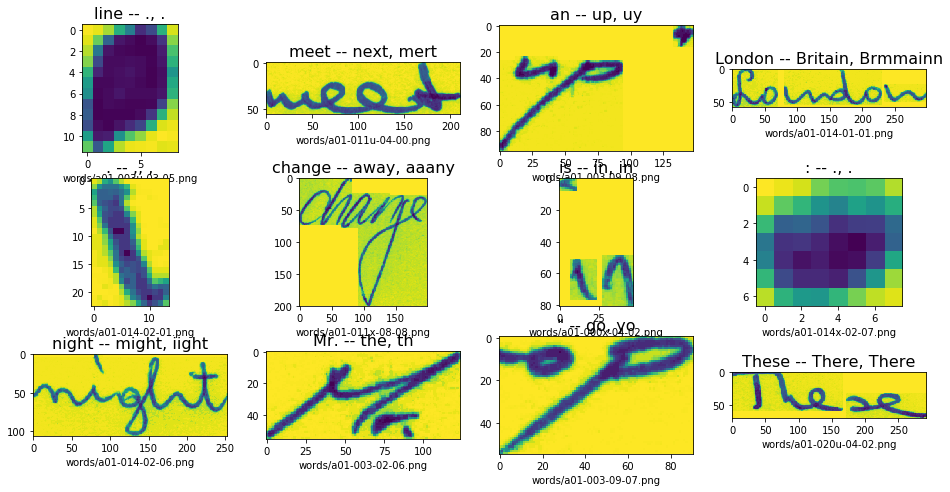

In [86]:
# incorrect words at random
plot_val_with_title(rand_by_correct(False, w_preds, word_targ, 16), "Incorrect Words")

Incorrect Chars
['words/a01-000u-00-03.png', 'words/a01-014-02-06.png', 'words/a01-007-06-02.png', 'words/a01-014-01-01.png', 'words/a01-014-01-01.png', 'words/a01-020u-04-02.png', 'words/a01-011x-08-08.png', 'words/a01-003-04-02.png', 'words/a01-003-04-02.png', 'words/a01-007-04-06.png', 'words/a01-003u-05-03.png', 'words/a01-014-04-06.png', 'words/a01-007-03-07.png', 'words/a01-014-01-01.png', 'words/a01-014-00-02.png', 'words/a01-011x-01-02.png']


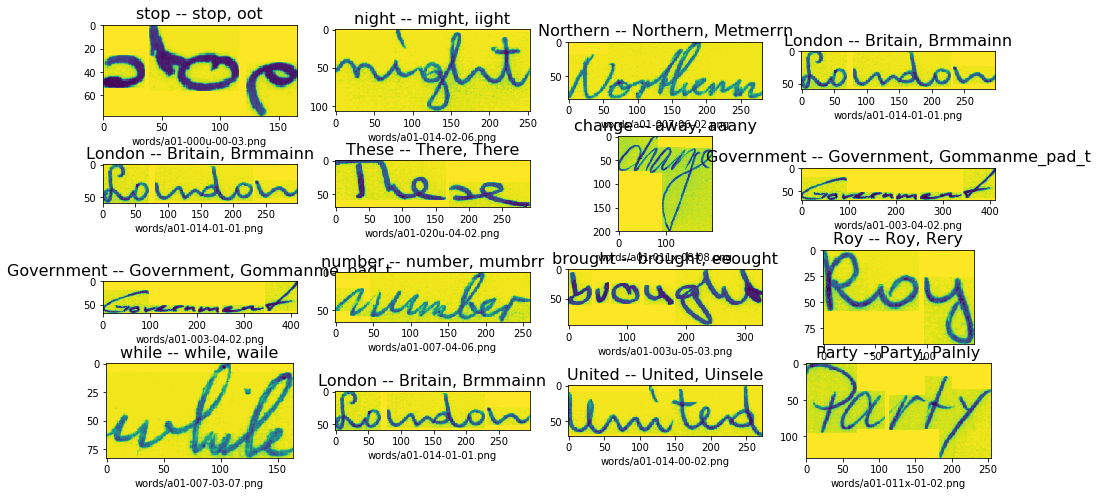

In [99]:
# incorrect words at random
plot_val_with_title(rand_by_correct(False, c_preds, char_targ, 16), "Incorrect Chars")

### Increase size

In [124]:
learn.load('words-chars64-.61loss')   # word_acc: .886, char_acc: .936

In [100]:
sz = 128

In [107]:
learn.set_data(md)

In [111]:
learn.model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

 75%|███████▍  | 424/566 [01:02<00:20,  6.83it/s, loss=8.72]

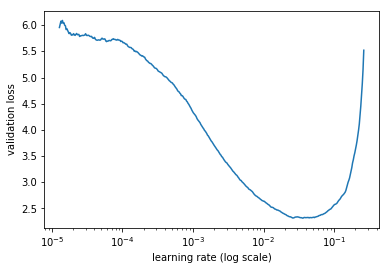

In [112]:
learn.lr_find()
learn.sched.plot()

In [113]:
lr = 1e-2

In [114]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   word_acc   char_acc        
    0      1.515134   1.546679   0.67012    0.870649  
    1      1.256237   1.2428     0.732286   0.884058        


[1.2427996987088479, 0.7322860964160552, 0.8840578568969818]

In [116]:
learn.save('words-chars128-last_layer-1.24')

In [116]:
learn.load('words-chars128-last_layer-1.24')

In [117]:
learn.unfreeze()

In [118]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   word_acc   char_acc         
    0      0.688951   0.651982   0.880932   0.926313  
    1      0.60453    0.565408   0.8999     0.938686         
    2      0.412503   0.496315   0.911765   0.944119         
    3      0.508851   0.543567   0.898145   0.939818         
    4      0.40148    0.47826    0.912851   0.949674         
    5      0.275117   0.442615   0.922794   0.956942         
    6      0.207984   0.438061   0.922042   0.958131         


[0.43806134624516263, 0.922042112697892, 0.9581309044185806]

In [119]:
learn.save('words-chars128-.43loss')   # word_acc: .922, char_acc: .958

### Predict

In [121]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
char_pred,word_pred = learn.model(x)

In [122]:
char_pred = char_pred.cpu()
word_pred = word_pred.cpu()

char_targ, word_targ = y[0].cpu(), y[1].cpu()
bs,num_chars = char_targ.shape

sl = 20
if num_chars<sl: char_targ = F.pad(char_targ, (0,sl-num_chars,0,0)) # rank2 tensor requires 4 padding values
char_targ = char_targ.long()
    
char_preds = char_pred.view(bs, 20, -1)   # convert to ([bs, sl, 84])
# char_preds = char_preds[:, :num_chars, :].contiguous()   # take only the first num_chars of char_pred

In [123]:
w_preds = np.argmax(word_pred.detach(), axis=1)
c_preds = np.argmax(char_preds.detach(), axis=2)

In [124]:
x = denorm(x)

Incorrect Words
['words/a01-011-00-01.png', 'words/a01-003-09-08.png', 'words/a01-003-02-06.png', 'words/a01-014x-02-07.png', 'words/a01-014x-05-04.png', 'words/a01-014-02-01.png', 'words/a01-003-09-07.png', 'words/a01-003u-03-05.png']


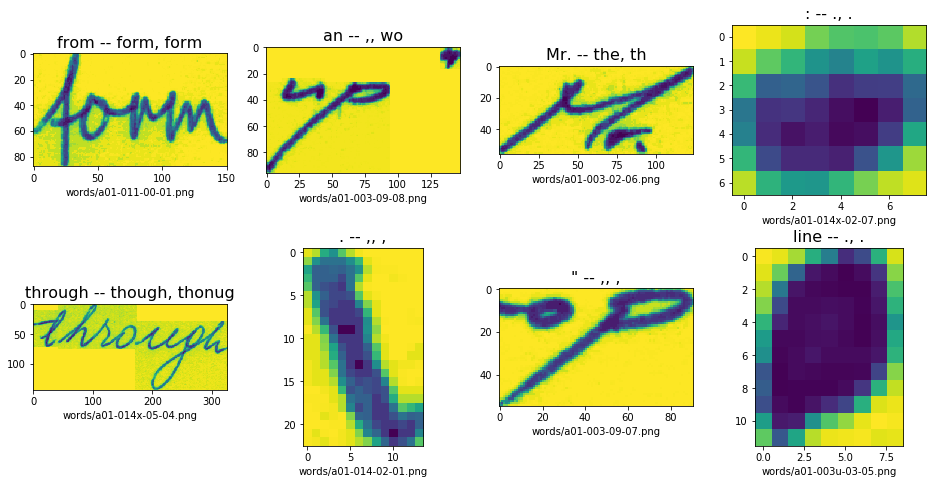

In [126]:
# incorrect words at random
plot_val_with_title(rand_by_correct(False, w_preds, word_targ, 8), "Incorrect Words")

Incorrect Chars
['words/a01-003u-05-03.png', 'words/a01-014x-05-04.png', 'words/a01-000x-00-06.png', 'words/a01-007-08-04.png', 'words/a01-003u-03-05.png', 'words/a01-007-04-06.png', 'words/a01-003u-03-05.png', 'words/a01-003-05-02.png', 'words/a01-014-01-01.png', 'words/a01-007-08-04.png', 'words/a01-014-02-01.png', 'words/a01-014-04-01.png', 'words/a01-007-08-04.png', 'words/a01-003u-03-05.png', 'words/a01-003-04-02.png', 'words/a01-003u-03-05.png']


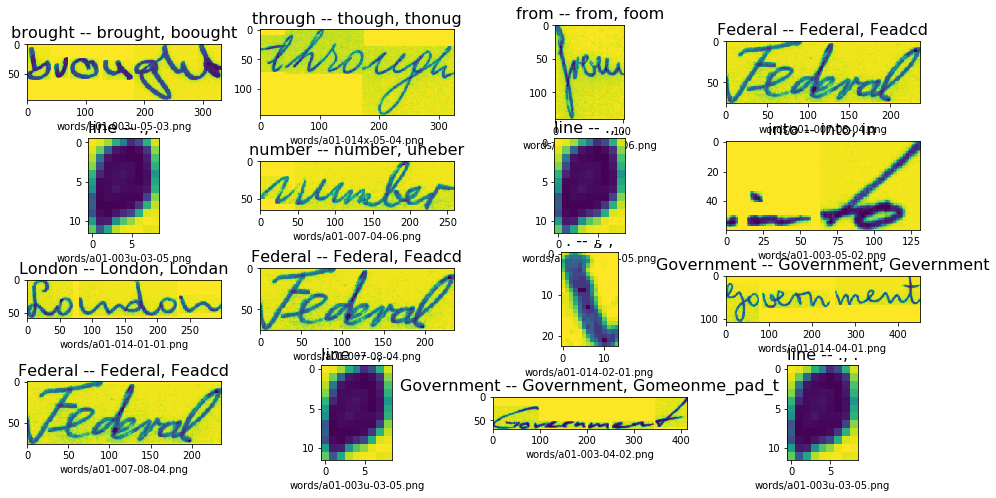

In [127]:
# incorrect chars at random
plot_val_with_title(rand_by_correct(False, c_preds, char_targ, 16), "Incorrect Chars")